<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>

**Copyright:** 2024 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Noemi Fazzini, Antonio Vecoli (MEEO)

# Copernicus Sentinel-3 SLSTR NRT - Fire Radiative Power (FRP) and Aerosol Optical Depth (AOD) - Level 2

The Copernicus Sentinel-3 mission provides critical data for monitoring Earth's atmosphere and surface, particularly through its Sea and Land Surface Temperature Radiometer (SLSTR). 

This module focuses on analyzing Sentinel-3 SLSTR Near Real-Time (NRT) data, specifically Fire Radiative Power (FRP) and Aerosol Optical Depth (AOD).

<div class="alert alert-block alert-info">
<b>How to access the data</b>
</div>

* A [EUMETSAT Earth Observation Portal account](https://eoportal.eumetsat.int/cas/login?service=https%3A%2F%2Feoportal.eumetsat.int%2FuserMgmt%2Fcallback%3Fclient_name%3DCasClient) to download data from the EUMETSAT Data Store 


This module has the following outline:
* [1 - Load Sentinel-3 SLSTR NRT FRP data to analyze its content](#load_s3_frp)
* [2 - Load and and pre-process NRT FRP computed from MWIR channel (3.7 um)](#load_mwir)
* [2 - Visualize data from Morning/Afternoon observations](#visualize_frp)
* [4 - Load Sentinel-3 SLSTR NRT AOD data to analyze its content](#load_s3_aod)
* [5 - Load and and pre-process NRT AOD at 550nm for both land and ocean](#load_aod)
* [6 - Visualize data from same satellite/orbit observations](#visualize_aod)

#### Load required libraries and define variables and coordinates

In [1]:
import re
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import display, Javascript, HTML

In [2]:
%run ../helper_functions.ipynb

In [32]:
latmin = 30
latmax = 50
lonmin = 15
lonmax = 40

start_day = '2023-08-21'

## FRP

The [Copernicus Sentinel-3 (S3) Near Real Time (NRT) Fire Radiative Power (FRP)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0207) product, implemented by EUMETSAT, detects and monitors the **immediate threats of any 'burning' events over an area size of 1 km<sup>2</sup>**. 

All threatening hotspots are identified and characterised within three hours from SLSTR observation sensing time.
The current version of the Near-Real-Time (NRT) S3 FRP processor is mainly applicable during the night while only a few daytime granules, with non-saturated background (i.e. no fires) radiance, are processed at this stage. The NRT S3 FRP product will become operational after a higher level of quality and maturity is reached, including the full processing of granules during daytime, a comprehensive global validation, and positive feedback by experts and users.

### <a id='load_s3_frp'></a>Load Sentinel-3 SLSTR Near-Real-Time FRP data to analyze its content

Sentinel-3 SLSTR NRT FRP data are disseminated  in `netCDF` format. The first step is to load the data file with xarray's `xr.open_dataset()` function.

Once the data file is loaded, you see that the data file has three dimensions: `columns`, `fires_MWIR1km_standard` and `rows`. The data and additional information, such as quality flags or latitude and longitude information, is stored as data variables.

There are four variable of interest:
- `FRP_MWIR` - Fire Radiative Power computed from MWIR channel (3.7 um) [MW], that detects less intensive fires with a temperature lower than 1100 Kelvin.
- `time` - Acquisition time of every observation
- `latitude`
- `longitude`

In [17]:
file_new = xr.open_dataset("data/s3/frp_new/FRP_MWIR1km_standard_S3A_SL_2_FRP____20230821T191818_20230821T192118_20240821T040741_0180_102_256______MAR_D_NR_003.SEN3.nc")
file_new

<xarray.Dataset> Size: 7MB
Dimensions:                            (fires_MWIR1km_standard: 42, rows: 1202,
                                        columns: 1500)
Dimensions without coordinates: fires_MWIR1km_standard, rows, columns
Data variables: (12/36)
    i                                  (fires_MWIR1km_standard) int16 84B ...
    j                                  (fires_MWIR1km_standard) int32 168B ...
    time                               (fires_MWIR1km_standard) datetime64[ns] 336B ...
    latitude                           (fires_MWIR1km_standard) float32 168B ...
    longitude                          (fires_MWIR1km_standard) float32 168B ...
    FRP_MWIR                           (fires_MWIR1km_standard) float32 168B ...
    ...                                 ...
    sat_zenith                         (fires_MWIR1km_standard) float32 168B ...
    sat_azimuth                        (fires_MWIR1km_standard) float32 168B ...
    eff_across_track_pixel_size        (fires_MWIR1km_standard) float32 168B ...
    eff_along_track_pixel_size         (fires_MWIR1km_standard) float32 168B ...
    convert_f3                         (fires_MWIR1km_standard) uint8 42B ...
    flags                              (rows, columns) uint32 7MB ...
Attributes: (12/17)
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20230821T191818_20230821T192118_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 03.01
    ...                     ...
    absolute_orbit_number:  39114
    start_time:             2023-08-21T19:18:18.016129Z
    stop_time:              2023-08-21T19:21:18.016129Z
    processing_baseline:    FRP_NRT.003.00.00
    track_offset:           998
    start_offset:           3549

### <a id='load_mwir'></a>Load and and pre-process NRT FRP computed from MWIR channel (3.7 um)

The `extract_data_from_filename` function is designed to extract the satellite identifier from a filename based on a predefined pattern. It uses a regular expression to search for the part of the filename that specifies the satellite (either S3A or S3B).

This function is useful for automating the extraction of relevant metadata from filenames for further data processing and analysis.

In [18]:
def extract_data_from_filename(filename):
    # Regex pattern to capture the satellite, date and time part in the filename
    pattern = r"FRP_MWIR1km_standard_(S3[AB])_SL_2_FRP"
    match = re.search(pattern, filename)
    if match:
        satellite = match.group(1)  # S3A or S3B
        return satellite  
    else:
        raise ValueError("Filename does not match expected pattern.")

The `preprocess_frp` function processes data to prepare it for analysis. It takes an xarray.Dataset object and a filename as input, and performs the following steps:

1. `fill_and_align`: It adjusts the size of the FRP_MWIR data along the specified dimension (ground_pixel) to ensure it matches a target size, filling with NaNs if necessary or truncating if the size exceeds the target. This is done to open all the intersted file as a single xarray.Dataset.

2. Masking and Statistics: The function masks invalid data values, computes various statistical measures (such as total, mean, standard deviation, minimum, and maximum of the FRP values), and counts the number of valid and total fire observations.

3. Data Preparation: It generates a new a xarray.DataArray object with latitude / longitude information as coordinate information from the processed data and aligns it to the target size.

4. Dataset Construction: It creates and returns a combined xarray.Dataset that includes the aligned FRP data and computed statistics, along with metadata extracted from the filename.

In [19]:
def preprocess_frp(ds, filename):
    target_size = 480 # Maximum size found across datasets

    def fill_and_align(da, target_size, dim='ground_pixel'):
        """
        Fill missing values and align the specified dimension to the target size.
        """
        current_size = da.sizes.get(dim, None)
        if current_size is not None:
            if current_size < target_size:
                # Pad with NaNs
                padding = target_size - current_size
                da = da.pad({dim: (0, padding)}, constant_values=np.nan)
            elif current_size > target_size:
                # Truncate
                da = da.isel({dim: slice(0, target_size)})
        else:
            # If dimension is missing, create a new dimension with NaNs
            da = da.expand_dims({dim: target_size})
            da = da.pad({dim: (0, target_size)}, constant_values=np.nan)
        
        return da

    # Variables of interest
    lat_frp = ds['latitude']    
    lon_frp = ds['longitude']
    frp_mwir = ds['FRP_MWIR']
    # first acquisition time 
    frp_time = ds['time'].values[0]
    
    # Masked array
    mask_flag = (frp_mwir != -1).compute()
    masked_frp_mwir = frp_mwir.where(mask_flag, drop=True)
    
    n_fire_tot           = len(lat_frp[:])
    n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

    FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
    FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
    FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
    FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
    FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

    # print(n_fire_tot, n_fire_MWIR)

    frp_mwir_da = generate_xr_from_1d_vec(file=ds,
                                        lat_path='latitude', 
                                        lon_path='longitude',
                                        variable=frp_mwir, 
                                        parameter_name='frp_mwir', 
                                        longname='FRP from MWIR channel', 
                                        no_of_dims=1, 
                                        unit='MW')

    frp_mwir_aligned = fill_and_align(frp_mwir_da, target_size)

    satellite = extract_data_from_filename(filename)

    # # Calculate some statistics and add as attributes
    ds_combined = xr.Dataset({
        'frp_mwir': frp_mwir_aligned,
        'n_fire_tot': n_fire_tot,
        'n_fire_MWIR': n_fire_MWIR,
        'FRP_sum': FRP_sum,
        'FRP_mean': FRP_mean,
        'FRP_std': FRP_std,
        'FRP_min': FRP_min,
        'FRP_max': FRP_max
    }, coords={'time': frp_time, 'satellite': satellite})
    return ds_combined
    

The code snippet loads and processes data from multiple NetCDF files in the source directory, applying the `preprocess_frp` function to each file, combining them along the time dimension with nested concatenation and outer join, and then sorts the resulting dataset by time.

In [20]:
frp_xr = xr.open_mfdataset('data/s3/frp_new/*.nc', 
                           concat_dim='time', 
                           combine='nested',
                           preprocess= lambda ds: preprocess_frp(ds, filename=ds.encoding['source']),
                           join='outer')
frp_xr = frp_xr.sortby('time')
frp_xr

<xarray.Dataset> Size: 105kB
Dimensions:      (time: 18, ground_pixel: 480)
Coordinates:
    latitude     (time, ground_pixel) float32 35kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    longitude    (time, ground_pixel) float32 35kB dask.array<chunksize=(1, 1), meta=np.ndarray>
  * time         (time) datetime64[ns] 144B 2023-08-21T08:02:01.798222 ... 20...
    satellite    (time) <U3 216B 'S3A' 'S3B' 'S3B' 'S3A' ... 'S3B' 'S3B' 'S3A'
Dimensions without coordinates: ground_pixel
Data variables:
    frp_mwir     (time, ground_pixel) float32 35kB dask.array<chunksize=(1, 1), meta=np.ndarray>
    n_fire_tot   (time) int64 144B 9 34 18 42 327 151 13 ... 31 73 35 109 15 147
    n_fire_MWIR  (time) int64 144B 9 34 18 42 327 151 13 ... 31 73 35 109 15 147
    FRP_sum      (time) float32 72B 592.4 2.898e+03 ... 162.1 3.609e+03
    FRP_mean     (time) float32 72B 65.83 85.25 129.6 15.5 ... 10.87 10.8 24.55
    FRP_std      (time) float32 72B 64.49 110.4 126.2 ... 8.865 14.32 29.63
    FRP_min      (time) float32 72B 9.714 8.267 28.77 2.682 ... 1.265 3.16 2.407
    FRP_max      (time) float32 72B 202.8 558.5 535.3 ... 37.83 63.41 107.5

### <a id='visualize_frp'></a> Visualize data from Morning/Afternoon observations

The code filters and visualizes Sentinel-3 SLSTR Fire Radiative Power (FRP) data by distinguishing between morning and afternoon observations for each unique date, creating scatter plots with color-coded FRP values on maps for both time periods.

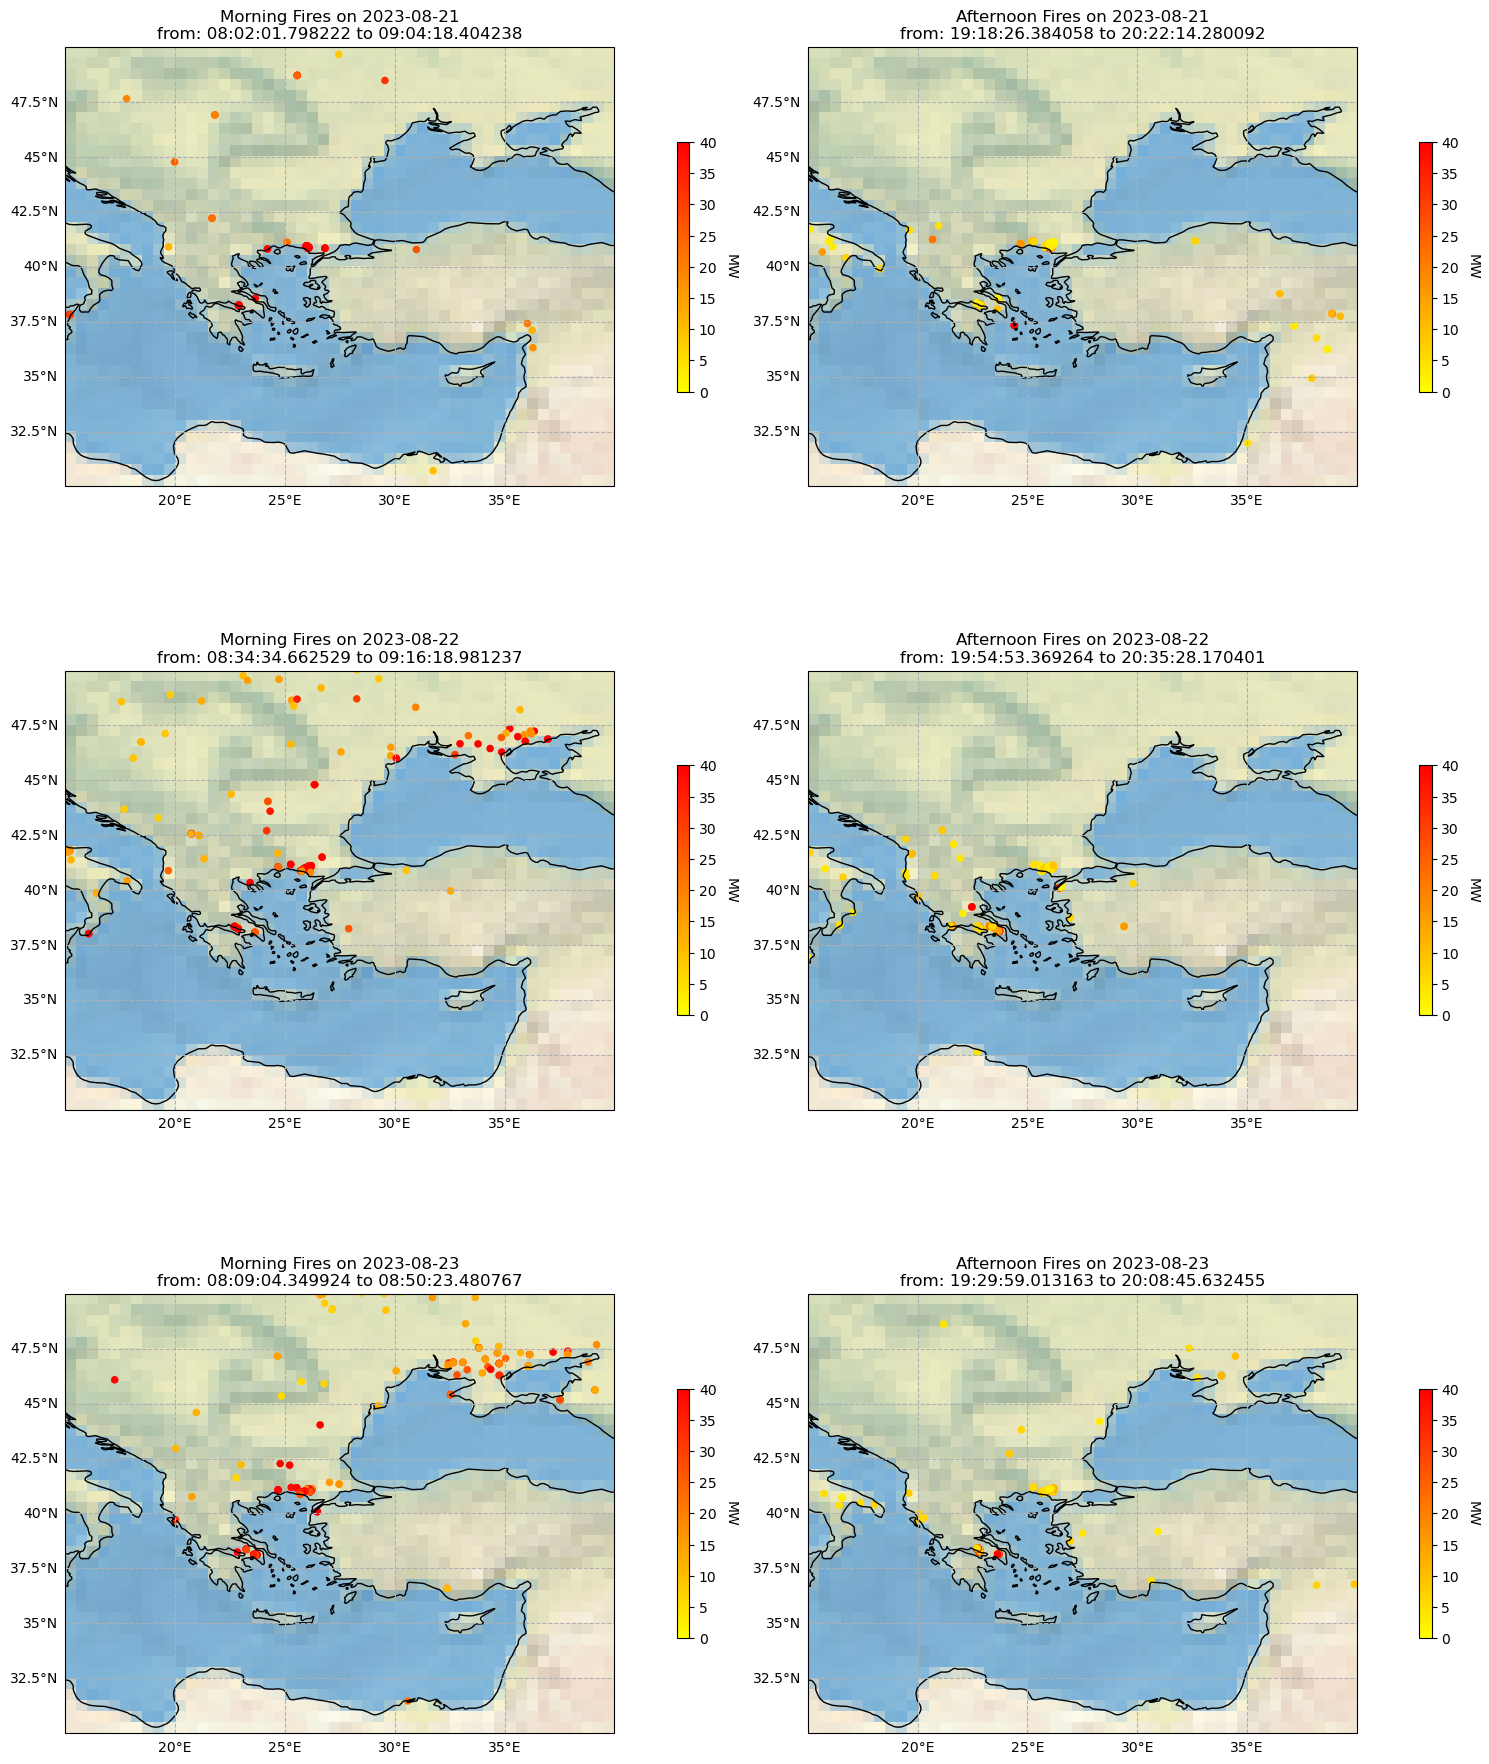

In [21]:
cutoff_time = pd.to_datetime("12:00:00").time()
unique_dates = np.unique(frp_xr.time.dt.date)

# Define datasets with labels for titles
datasets = {
    'Morning': lambda date: frp_xr.where(
        (frp_xr.time.dt.time < cutoff_time) & (frp_xr.time.dt.date == date), drop=True
    ),
    'Afternoon': lambda date: frp_xr.where(
        (frp_xr.time.dt.time >= cutoff_time) & (frp_xr.time.dt.date == date), drop=True
    )
}


fig, axes = plt.subplots(len(unique_dates), 2, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for idx, date in enumerate(unique_dates):
    morning_data = datasets['Morning'](date)
    morning_start_time = pd.to_datetime(morning_data.time.values.min()).time()
    morning_end_time = pd.to_datetime(morning_data.time.values.max()).time()
    ax_morning = axes[idx * 2]
    scatter_morning = ax_morning.scatter(
        morning_data.longitude, morning_data.latitude, c=morning_data['frp_mwir'].values,
        transform=ccrs.PlateCarree(), cmap='autumn_r', vmin=0, vmax=40,
        s=30, edgecolor='none')
    ax_morning.set_title(f'Morning Fires on {str(date)}\nfrom: {morning_start_time} to {morning_end_time}')


    ax_morning.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    ax_morning.coastlines()
    ax_morning.stock_img()
    gl = ax_morning.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    cbar = plt.colorbar(scatter_morning, ax=ax_morning, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('MW', rotation=270, labelpad=15)

    # Plot Afternoon Data
    afternoon_data = datasets['Afternoon'](date)
    afternoon_start_time = pd.to_datetime(afternoon_data.time.values.min()).time()
    afternoon_end_time = pd.to_datetime(afternoon_data.time.values.max()).time()
    ax_afternoon = axes[idx * 2 + 1]
    scatter_afternoon = ax_afternoon.scatter(
        afternoon_data.longitude, afternoon_data.latitude, c=afternoon_data['frp_mwir'].values,
        transform=ccrs.PlateCarree(), cmap='autumn_r', vmin=0, vmax=40,
        s=30, edgecolor='none')
    ax_afternoon.set_title(f'Afternoon Fires on {str(date)}\nfrom: {afternoon_start_time} to {afternoon_end_time}')


    ax_afternoon.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    ax_afternoon.coastlines()
    ax_afternoon.stock_img()
    gl = ax_afternoon.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}
    
    cbar = plt.colorbar(scatter_afternoon, ax=ax_afternoon, orientation='vertical', fraction=0.02, pad=0.1)
    cbar.set_label('MW', rotation=270, labelpad=15)
    

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<hr>

## AOD

The [Copernicus Sentinel-3 SLSTR Near-Real-Time (NRT) Aerosol Optical Depth (AOD)](https://navigator.eumetsat.int/product/EO:EUM:DAT:0306?query=SLSTR%20Level%202%20Aerosol%20Optical%20Depth%20in%20NRT%20-%20Sentinel-3&s=advanced)  product quantifies the abundance of all aerosol particles suspended in the air and monitors their global distribution and long-range transport, at the scale of 9.5 x 9.5 km2. 

Aerosol Optical Depth is often used as a proxy for the amount of aerosols in the air.

The NRT S3 AOD product is only applicable during daytime. The current version of the product is considered as 'preliminary operational' over ocean surfaces, and 'demonstrational' over land surfaces.

All these observations are made available in less than three hours from the SLSTR observation sensing time.

### <a id='load_s3_aod'></a> Load Sentinel-3 SLSTR NRT AOD data to analyze its content

The Near-Real-Time Sentinel-3 Aerosol Optical Depth data are disseminated in `netCDF`. `netCDF` data can be loaded with the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `xr.open_dataset()`. 

You see that the data file contains two `dimensions`:
* `columns` and
* `rows`

Variables of interest are:
* `AOD_550`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers ocean surfaces.*)
* `AOD_550_Land`: it is the Aerosol Optical Depth at 550nm. (*Note: it only covers land surfaces.*)


In [22]:
file_new = xr.open_dataset("data/s3/aod/S3A_SL_2_AOD____20230822T073101_20230822T073600_20230822T094543_0299_102_263______MAR_O_NR_003.SEN3.nc")
file_new

<xarray.Dataset> Size: 8MB
Dimensions:                                (rows: 211, columns: 157)
Coordinates:
    longitude                              (rows, columns) float32 133kB ...
Dimensions without coordinates: rows, columns
Data variables: (12/57)
    AOD_550                                (rows, columns) float32 133kB ...
    AOD_550_Land                           (rows, columns) float32 133kB ...
    AOD_550_uncertainty                    (rows, columns) float32 133kB ...
    AOD_550_uncertainty_Land               (rows, columns) float32 133kB ...
    AOD_550_Merged_OceanLand               (rows, columns) float32 133kB ...
    AOD_670                                (rows, columns) float32 133kB ...
    ...                                     ...
    scattering_angle_oblique               (rows, columns) float32 133kB ...
    cloud_fraction_nadir                   (rows, columns) float32 133kB ...
    cloud_fraction_oblique                 (rows, columns) float32 133kB ...
    aod_quality_flags                      (rows, columns) uint16 66kB ...
    SLN_L1b_quality_flags                  (rows, columns) uint32 133kB ...
    SLO_L1b_quality_flags                  (rows, columns) uint32 133kB ...
Attributes: (12/17)
    title:                  Surface directional Reflectance, retrieved and de...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_AOD____20230822T073101_20230822T073600_2...
    institution:            MAR
    source:                 IPF-SL-2-AOD 04.00
    ...                     ...
    absolute_orbit_number:  39121
    start_time:             2023-08-22T07:31:01.309841Z
    stop_time:              2023-08-22T07:36:00.395855Z
    processing_baseline:    AOD_NRT.003.00.00
    track_offset:           105
    start_offset:           1459

### <a id='load_aod'></a>Load and and pre-process NRT AOD at 550nm for both land and ocean

This function takes a filename as input and uses a regular expression pattern to extract specific pieces of information from the filename. It identifies:
* The satellite identifier (S3A or S3B).
* The start time of the observation in the format YYYYMMDDTHHMMSS.
* The orbit number (extracted from the last three digits of the filename pattern)

In [26]:
def extract_data_from_filename(filename):
    # Regex pattern to capture the satellite, datetime, and orbit number in the filename
    # Updated pattern to correctly identify the third segment as the orbit number
    pattern = r"(S3[AB])_SL_2_AOD____(\d{8}T\d{6})_\d{8}T\d{6}_\d{8}T\d{6}_(\d{4})_(\d{3})_(\d{3})"
    match = re.search(pattern, filename)
    if match:
        satellite = match.group(1)  # S3A or S3B
        datetime_str = match.group(2)  # Start time as YYYYMMDDTHHMMSS
        orbit_number = match.group(5)  # Orbit number (last 3 digits in the pattern)
        return satellite, datetime.strptime(datetime_str, '%Y%m%dT%H%M%S'), orbit_number
    else:
        raise ValueError("Filename does not match expected pattern.")

The `preprocess_aod` function processes an AOD dataset by:

1. Selecting relevant variables
2. Extracting the first acquisition time (`aod_time`).
3. Standardizing the dataset to include only the first 210 rows, to ensure all files have the same size for combining.
4. Extracting metadata (satellite name and orbit number) from the filename.

In [23]:
def preprocess_aod(ds, filename):
    ds = ds[['AOD_550', 'AOD_550_Land', 'latitude', 'longitude', 'time_reference_a']]
    # First acquisition time
    aod_time = ds['time_reference_a'].values[0]

    # Standardize the dimension size (ensure all files have the same size for combining)
    ds = ds.isel(rows=slice(0, 210))

    satellite, _, orbit_number = extract_data_from_filename(filename)

    # Assigning new coordinates for satellite, time, and orbit_number.
    ds = ds.assign_coords(satellite=satellite)
    ds = ds.assign_coords(time=aod_time)
    ds = ds.assign_coords(orbit_number=int(orbit_number))  # Orbit number as an integer

    return ds

The code snippet loads and processes data from multiple NetCDF files in the source directory, applying the `preprocess_aod` function to each file, combining them along the time dimension with nested concatenation and outer join, and then sorts the resulting dataset by time.

In [24]:
aod_xr = xr.open_mfdataset('data/s3/aod/*.nc', 
                           concat_dim='time', 
                           combine='nested',
                           join='outer',
                           drop_variables= ['time'],
                           preprocess=lambda ds: preprocess_aod(ds, filename=ds.encoding['source']))

aod_xr = aod_xr.sortby('time')
aod_xr

<xarray.Dataset> Size: 5MB
Dimensions:           (time: 9, rows: 210, columns: 157)
Coordinates:
    longitude         (time, rows, columns) float32 1MB dask.array<chunksize=(1, 210, 157), meta=np.ndarray>
    satellite         (time) <U3 108B 'S3B' 'S3B' 'S3A' ... 'S3B' 'S3A' 'S3A'
  * time              (time) datetime64[ns] 72B 2023-08-21T08:59:48.794525 .....
    orbit_number      (time) int64 72B 107 107 263 121 264 264 135 278 278
Dimensions without coordinates: rows, columns
Data variables:
    AOD_550           (time, rows, columns) float32 1MB dask.array<chunksize=(1, 210, 157), meta=np.ndarray>
    AOD_550_Land      (time, rows, columns) float32 1MB dask.array<chunksize=(1, 210, 157), meta=np.ndarray>
    latitude          (time, rows, columns) float32 1MB dask.array<chunksize=(1, 210, 157), meta=np.ndarray>
    time_reference_a  (time, rows) datetime64[ns] 15kB dask.array<chunksize=(1, 210), meta=np.ndarray>
Attributes: (12/17)
    title:                  Surface directional Reflectance, retrieved and de...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_AOD____20230822T073101_20230822T073600_2...
    institution:            MAR
    source:                 IPF-SL-2-AOD 04.00
    ...                     ...
    absolute_orbit_number:  39121
    start_time:             2023-08-22T07:31:01.309841Z
    stop_time:              2023-08-22T07:36:00.395855Z
    processing_baseline:    AOD_NRT.003.00.00
    track_offset:           105
    start_offset:           1459

### <a id='visualize_aod'></a> Visualize data from same satellite/orbit observations

This code visualizes aerosol optical depth (AOD) data over time, grouped by satellite orbit.

1. Group the data by date and orbit number: the dataset is grouped based on the orbit_number variable, creating separate groups for each unique orbit.
2. For each orbit group, iterate through the time points in the group and plot AOD data over the ocean (`AOD_550`) and land (`AOD_550_Land`), along with `latitude` and `longitude`

DatasetGroupBy, grouped over 'orbit_number'
6 groups with labels 107, 121, 135, 263, 264, 278.


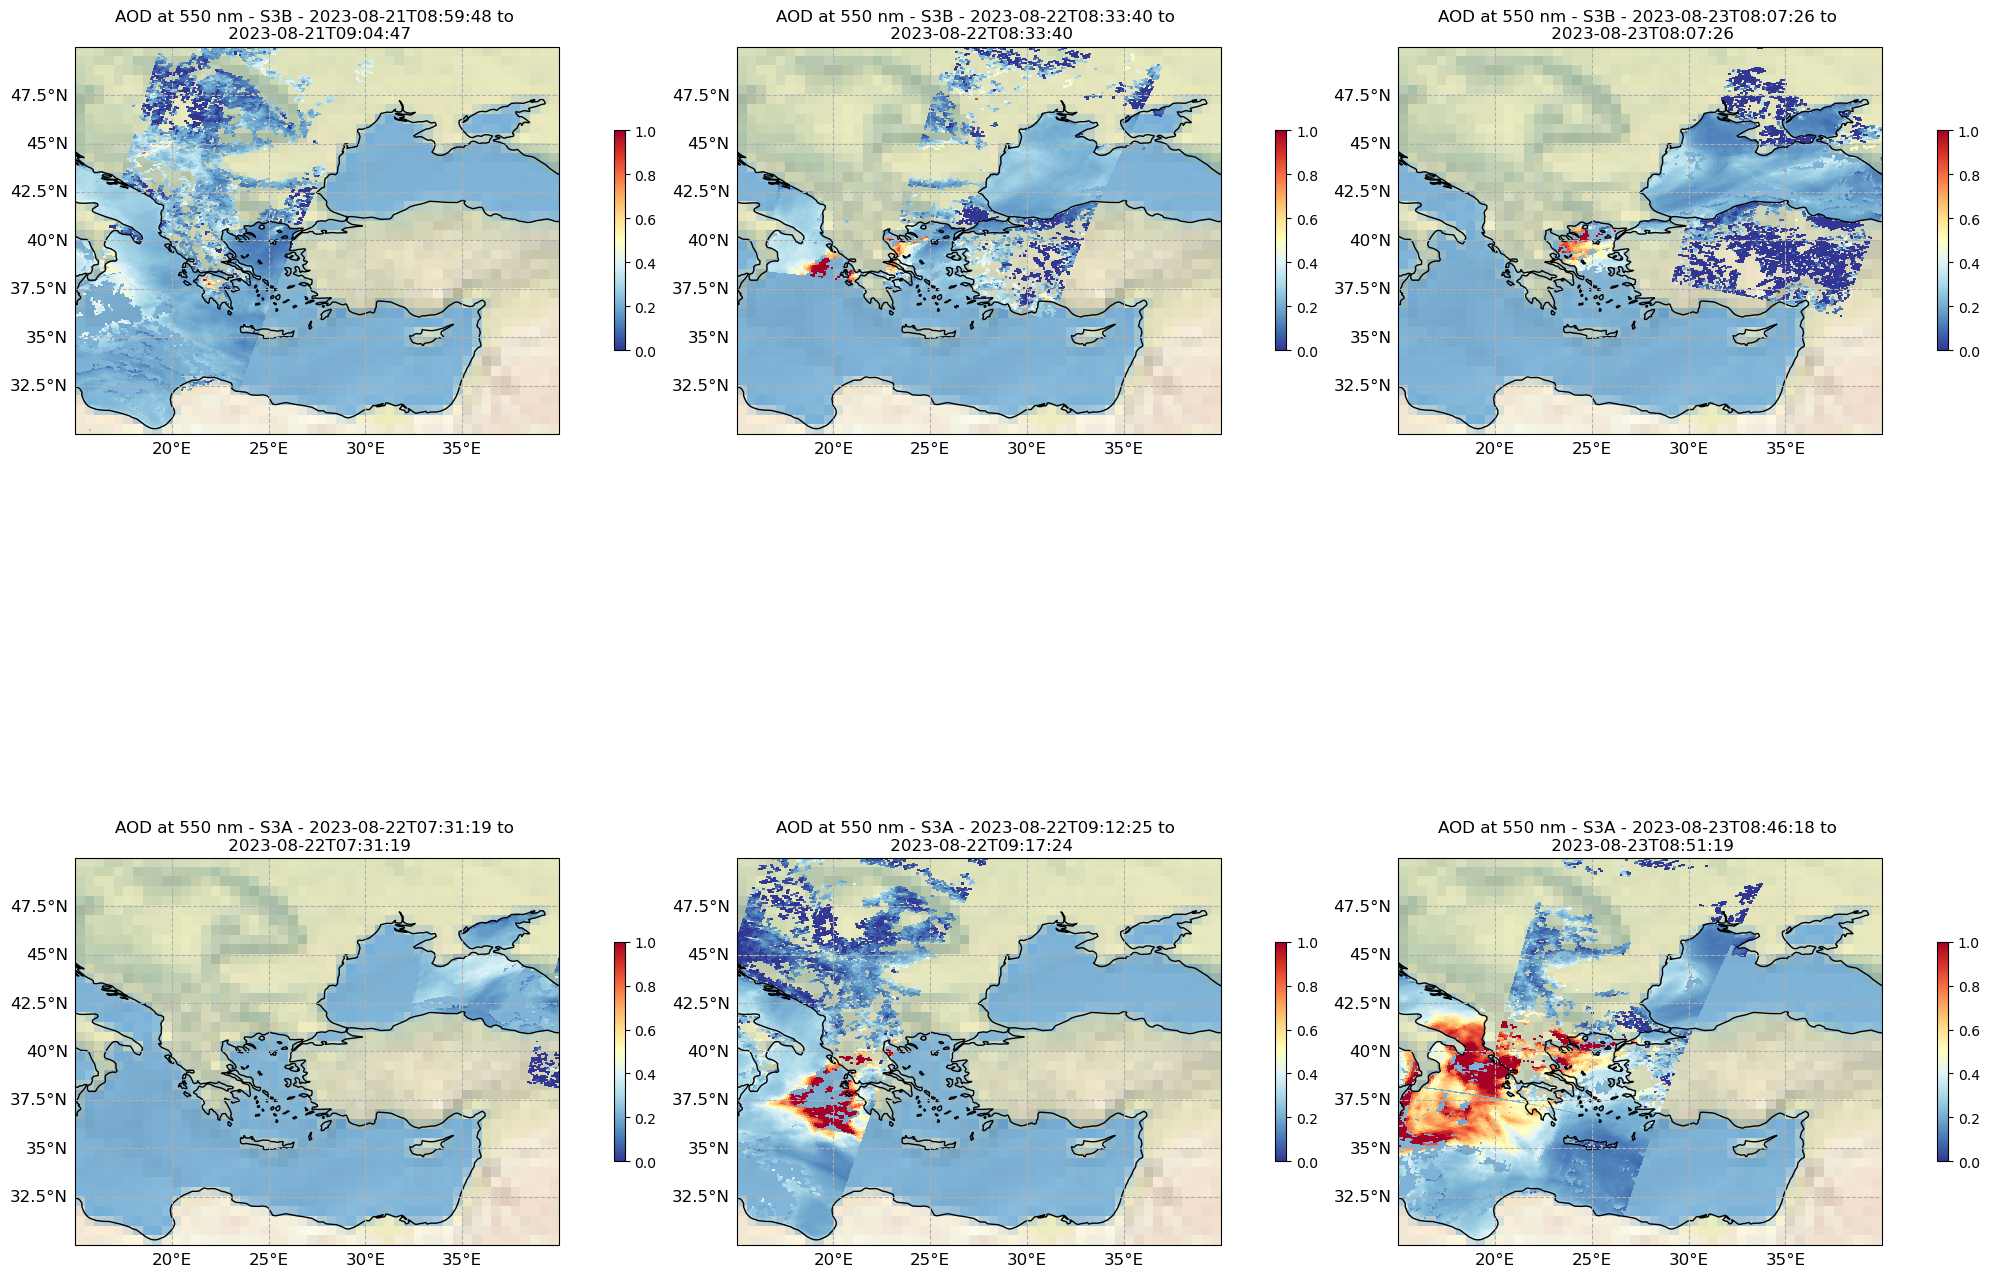

In [25]:
# Group by day and orbit
day_orbit_groups = aod_xr.groupby('orbit_number')
print(day_orbit_groups)
# Number of unique (day, orbit) combinations
n_groups = len(day_orbit_groups)


# Create a figure with a subplot for each group
fig, axes = plt.subplots(2, 3, figsize=(20,20), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, (key, data) in enumerate(day_orbit_groups):
    ax = axes[i] if n_groups > 1 else axes  # Handles case with only one subplot
    # Aggregate data over time for each group
    for time_index in range(len(data.time)):
        # Select data for this time index
        aod_ocean = data['AOD_550'].isel(time=time_index)
        aod_land = data['AOD_550_Land'].isel(time=time_index)
        latitude = data['latitude'].isel(time=time_index)
        longitude = data['longitude'].isel(time=time_index)
        
        # Plot AOD over ocean and land
        img1 = ax.pcolormesh(longitude, latitude, aod_ocean, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, cmap='RdYlBu_r')
        img2 = ax.pcolormesh(longitude, latitude, aod_land, transform=ccrs.PlateCarree(), vmin=0, vmax=1.0, cmap='RdYlBu_r')
    
    # Set plot title and extent
    unique_satellites = np.unique(data.satellite.values)
    unique_orbits = np.unique(data.orbit_number.values)
    time_range = f"{np.datetime_as_string(data.time.values.min(), unit='s')} to \n {np.datetime_as_string(data.time.values.max(), unit='s')}"
    ax.set_title(f'AOD at 550 nm - {", ".join(unique_satellites)} - {time_range}')
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.stock_img()
    
    # Configure gridlines
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}

    # Add colorbar
    plt.colorbar(img1, ax=ax, orientation='vertical', fraction=0.02, pad=0.1)

# Adjust layout
plt.subplots_adjust(wspace=0.7, hspace=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

<hr>

### Other resources

Some code in this notebook was adapted from the following sources: 
* https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/40_exercises/422_Sentinel-3_SLSTR_NRT_FRP_L2_exercise.ipynb
* https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/20_data_exploration/253_Sentinel-3_SLSTR_NRT_AOD_L2_load_browse.ipynb